# Length Finder Test for an Optical Multimode Fibre
Using my knowledge on constructing neural networks, try to make one that can find the length of a fibre given input and output data and an initial guess within error measurement range.

In [1]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker
import random

import torch
import torch.nn as nn
from torch.nn import Parameter

# Importing Data
PIM_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Modes.mat")
modes = PIM_data["F2"].transpose(2,0,1) # Modes
PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

beta_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Beta.mat")
beta = beta_data["Beta"] # Phase velocities for each mode
beta_torch = torch.tensor(beta, dtype=torch.cfloat)

# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")


Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [19]:
# Functions

# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def TM(length):
    """Forms a transmission matrix, TM, based on externally generated PIMs and their corresponding phase velocities, built into the Fibre class.
    * length = Length of the MMF"""
    
    # Create the real space to PIM matrix
    pim = torch.column_stack((PIMs_torch[0].flatten(),PIMs_torch[1].flatten()))
    for i in np.arange(2,42,1):
        pim = torch.column_stack((pim, PIMs_torch[i].flatten()))

    # Take the conjugate transpose of the pim matrix to be used in returning the field back to pixel coords
    pim_dag = torch.transpose(torch.conj(pim), dim0=0, dim1=1).to(device)

    # Make a diagonal PIM to PIM TM (each term is exp(i*L*beta), where L is the length of the MMF)
    beta_arr = torch.diag(torch.exp(1j*length*beta_torch.flatten().to(device)))
    
    # Combine each matrix to make the full TM for the MMF
    return pim.to(device) @ beta_arr @ pim_dag

# Make a propagate function to help save time (and less complexity) in the future
def propagate(input_field, length, pytorch=True):
    """Takes an input field and the transmission matrix of a multimode optical fibre and finds the output after propagating for a given distance."""
    # Give option to use TorchOptics fields or not!
    output_field_vector = TM(length) @ vectorise(input_field)
    output_field = unvectorise(output_field_vector,31)
    if pytorch == 1:
        torch_field = torch.from_numpy(output_field).to(device) 
        return torch_field
    else: 
        return output_field
    
def loss_fn(output, target):
    return (output.abs().square() - target.abs().square()).abs().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i].abs().square() - targets[i].abs().square()).abs().sum()
    loss /= len(outputs)
    return loss


In [11]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Normalised Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

In [4]:
# Model Class
class LengthModel(nn.Module):

    def __init__(self, length=0.15):
        super(LengthModel, self).__init__()

        # Parameters
        self.length = nn.Parameter(data=torch.tensor([length], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        output_vector = TM(self.length) @ vectorise(input_field)
        output_field = unvectorise(output_vector,31)
        return output_field

## Code

### Training Data

C:\Users\elija\AppData\Local\Temp\ipykernel_15004\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

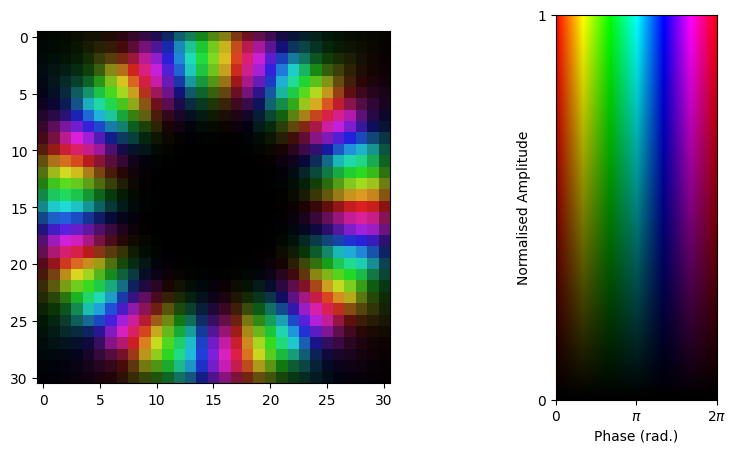

In [21]:
# Make the input and target data
# Want to use all modes to avoid issues with the periodical nature of the loss function with only 1 mode.
input_data = PIMs_torch.to(device)
Field(input_data[0].cpu()).visualise()

prop_dist = torch.tensor([0.2])
target_data = propagate(PIMs_torch[0].to(device), prop_dist)[None,:,:]
for i in np.arange(1,PIMs_torch.size(dim=0),1):
    target_data = torch.cat((target_data, propagate(PIMs_torch[i], prop_dist)[None,:,:]), dim=0)

target_data = target_data.to(device)
Field(target_data[0].cpu()).visualise()

print(input_data.shape)
print(target_data.shape)

### Training Loop

In [8]:
model = LengthModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    output = model(input_data[0])

    loss = loss_fn(output, target_data[0])
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")

Epoch 0, Loss: 0.022832874208688736, length: 0.14990000426769257
Epoch 100, Loss: 0.022535596042871475, length: 0.15001608431339264
Epoch 200, Loss: 0.021573051810264587, length: 0.15001240372657776
Epoch 300, Loss: 0.021612808108329773, length: 0.1499709188938141
Epoch 400, Loss: 0.021604593843221664, length: 0.1500147432088852
Epoch 500, Loss: 0.02367967739701271, length: 0.14997699856758118
Epoch 600, Loss: 0.02162308059632778, length: 0.14999701082706451
Epoch 700, Loss: 0.022477522492408752, length: 0.15000198781490326
Epoch 800, Loss: 0.02340284176170826, length: 0.15000706911087036
Epoch 900, Loss: 0.022485263645648956, length: 0.14999344944953918

Final Loss: 0.02106059528887272
Final length: 0.15000389516353607


In [9]:
# Training Loop
model = LengthModel().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimiser.zero_grad()
    fields_out = []
    for i in range(input_data.shape[0]):
        fields_out.append(model(input_data[i]))
    loss = loss_func(fields_out, target_data)
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")

Epoch 0, Loss: 0.02703012153506279, length: 0.14990000426769257
Epoch 100, Loss: 0.02776908688247204, length: 0.14998701214790344
Epoch 200, Loss: 0.027149388566613197, length: 0.14993523061275482
Epoch 300, Loss: 0.026271866634488106, length: 0.14994512498378754
Epoch 400, Loss: 0.026715796440839767, length: 0.1499784290790558
Epoch 500, Loss: 0.027066169306635857, length: 0.15000799298286438
Epoch 600, Loss: 0.027311064302921295, length: 0.14995624125003815
Epoch 700, Loss: 0.027556292712688446, length: 0.14993904531002045
Epoch 800, Loss: 0.027491778135299683, length: 0.14996163547039032
Epoch 900, Loss: 0.02683229371905327, length: 0.1499382108449936

Final Loss: 0.027311068028211594
Final length: 0.149957537651062


0
100
200
300
400
500
600
700
800
900


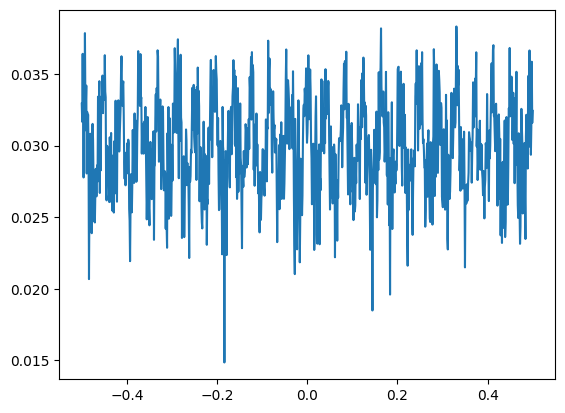

In [10]:
loss = []
xs = torch.from_numpy(np.linspace(-0.5,0.5,1000))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    fields_out = []
    if i % 100 == 0:
        print(i)
    for j in range(input_data.shape[0]):
        fields_out.append(model(input_data[j]))
    loss.append(loss_func(fields_out, target_data).cpu().detach().numpy())

plt.plot(xs,loss)